In [1]:


from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score

def input_mlflow(cv_r_v,increment_number,X_train, y_train,pipeline,run_name,experiment_id,X_test,y_test):
    

    for wi in range(len(cv_r_v)):
        
        #====================skema===================
        cols_spec = []
        data_map = {
                'int64': 'integer',
                'float64': 'double',
                'bool': 'boolean',
                'str': 'string',
                'object': 'string',
                "date": 'datetime'
            }

        for name, dtype in X_train.dtypes.to_dict().items():
            cols_spec.append(ColSpec(name=name, type=data_map[str(dtype)]))
        input_schema = Schema(inputs=cols_spec)
        output_schema = Schema([ColSpec(name="label", type="string")])
        #parameter = ParamSpec(name="model_name", dtype="string", default="model1")
        #param_schema = ParamSchema(params=[parameter])
        model_signature = ModelSignature(inputs=input_schema, outputs=output_schema)#, params=param_schema)
        #print("MODEL SIGNATURE")
        #print(model_signature.to_dict())

        model_signature = infer_signature(X_train, y_train)#, params={"model_name": "model1"})
        #print("MODEL SIGNATURE")
        #print(model_signature.to_dict())

        
        
        
        
        #====================buat run baru===================
        run_name_with_increment = f"{run_name}__{increment_number}"
            # Membuka run MLflow
        with mlflow.start_run(run_name=run_name_with_increment, experiment_id=experiment_id) as run:
            # Mendapatkan run_id
            run_id = mlflow.active_run().info.run_id
        
        print(f"mlruns/{experiment_id}/{run_id}/artifacts/grid_search__{increment_number}")
        increment_number=increment_number+1
        
        
        #====================buat parameter model dan metric===================

        # Definisikan grid parameter untuk dicari
        param_grid = cv_r_v[wi]
        
        #====================model===================

        # Inisialisasi GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=5,  scoring='accuracy')

        # Lakukan pencarian grid
        grid_search.fit(X_train, y_train)
        
            
        #====================parameter===================
        pipe=grid_search.best_estimator_
        
        
        first_step_name = list(pipe.named_steps.keys())[0:len(pipe)]
        

        for i in range(len(pipe)):
            # Mendapatkan parameter dari langkah 'sca'
            nama=first_step_name[i]
            sca_params = pipe.get_params()[nama]

                # Membuka run MLflow
            with mlflow.start_run( experiment_id=experiment_id,run_id=run_id) as run:

                # Log parameter secara otomatis menggunakan loop
                for param_name, param_value in sca_params.get_params().items():
                    param_name=nama+'__'+param_name
                    #print(param_name,param_value)
                    mlflow.log_param(param_name, param_value)
                    
                    
                #====================metric===================
                #matric
                hasil_test=grid_search.predict(X_test)
 
                
                
                
                                # Menghitung akurasi
                accuracy = accuracy_score(y_test, hasil_test)

                # Menghitung F1 score
                f1 = f1_score(y_test, hasil_test,average='macro')

                # Menghitung recall
                recall = recall_score(y_test, hasil_test,average='macro')

                
                
                                # Menghitung precision
                precision = precision_score(y_test, hasil_test,average='macro')


   
                

                # log model 
                mlflow.sklearn.log_model(sk_model=grid_search, artifact_path="grid_search__"+str(increment_number-1),signature=model_signature)

                metrics = {
                    'mean_test_score':pd.DataFrame(grid_search.cv_results_)['mean_test_score'].values[0],
                    "accuracy": accuracy,
                    "f1": f1,
                    "recall": recall,
                    "precision": precision,
         
                }

                mlflow.log_metrics(metrics)
                
                
        mlflow.end_run()
    print('selesai')

        
    return increment_number


     

def ambil_best(grid_search,n):
    cv_r=grid_search.copy()
    cv_r_v=cv_r.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
    cv_r_v=cv_r_v.head(n)['params'].values

    for wi in range(len(cv_r_v)):

        for i in list(cv_r_v[wi]):

            cv_r_v[wi][i]=[cv_r_v[wi][i]]


    return cv_r_v


In [2]:

def test(model_paths,X_test2,y_test):
    ii=1
    for i, model_path in enumerate(model_paths, start=1):
        print(f'\n\n================================| model {ii} |==========================================')
        
        model = mlflow.sklearn.load_model(model_path)
        y_pred = model.predict(X_test2)
        print(f"Classification Report for model {model_path[-2:]}:")
        print(classification_report(y_test, y_pred))
        print(f"Confusion Matrix for model {model_path[-2:]}:\n", confusion_matrix(y_test, y_pred), '\n\n')
        
        ii=ii+1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score
# import libraries

import scipy.stats as stats




import statsmodels.api as sm




from scipy.stats import shapiro,normaltest,kstest,jarque_bera
import pingouin as pg
from pingouin import kruskal




from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import mlflow



import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from scipy.stats import chi2_contingency, fisher_exact

In [4]:


from mlflow.models.signature import ModelSignature
from mlflow.models.signature import infer_signature
from mlflow.types.schema import Schema
from mlflow.types.schema import ParamSchema
from mlflow.types.schema import ParamSpec
from mlflow.types.schema import ColSpec

import pandas as pd
from typing import Tuple


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score


## Data

In [5]:
df = pd.read_csv('data/data_csv/data_bersih.csv')

In [6]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


## Train|Test Split and Scaling Data

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [9]:
len(X)

3000

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=421)

In [11]:
y_test.value_counts()

1    310
0    290
Name: Cancer Present, dtype: int64

In [12]:
from sklearn.feature_selection import mutual_info_classif
mutual_info=mutual_info_classif(X_train, y_train)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

Gene Two    0.302933
Gene One    0.228893
dtype: float64

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
scaler = StandardScaler()

In [15]:
knn = KNeighborsClassifier()

In [16]:
# Highly recommend string code matches variable name!
operations = [('scaler',scaler),('knn',knn)]

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
pipe = Pipeline(operations)

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
X_train.shape, X_test.shape

((2400, 2), (600, 2))

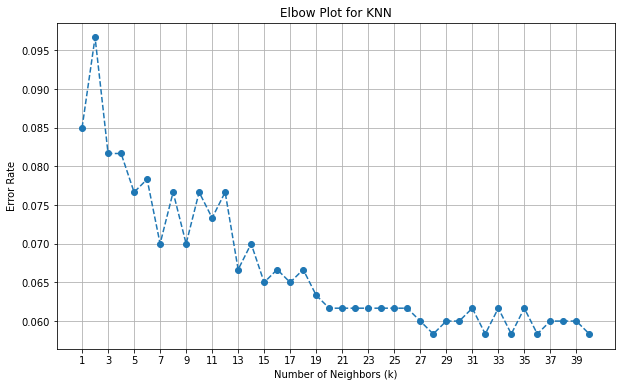

In [21]:

error_rate = []

for k in range(1, 41):  # Testing k values from 1 to 40
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error_rate.append(np.mean(y_pred != y_test))


plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), error_rate, marker='o', linestyle='--')
plt.title('Elbow Plot for KNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.xticks(range(1, 41, 2))
plt.grid(True)
plt.show()

In [22]:
param_grid = {'knn__n_neighbors': list(range(13,30)),
              'knn__leaf_size':list(range(2,20)),
              'knn__algorithm':['ball_tree','kd_tree','brute'],
              'knn__weights':['uniform', 'distance'],
              'knn__metric': ['manhattan', 'euclidean','chebyshev']
             }

full_cv_classifier_nominkowski = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy', n_jobs=2)

full_cv_classifier_nominkowski.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__leaf_size': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19],
                         'knn__metric': ['manhattan', 'euclidean', 'chebyshev'],
                         'knn__n_neighbors': [13, 14, 15, 16, 17, 18, 19, 20,
                                              21, 22, 23, 24, 25, 26, 27, 28,
                                              29],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [23]:
df_1 = pd.DataFrame(full_cv_classifier_nominkowski.cv_results_)
df_1.drop_duplicates(subset=['mean_test_score', 'std_test_score', 'rank_test_score'], inplace=True)
df_1 = df_1.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
df_1.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__leaf_size,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1414,0.005341,0.006704,0.063328,0.011564,ball_tree,15,chebyshev,23,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.920833,0.941667,0.941667,0.941667,0.937500,0.008333,1
88,0.011234,0.003112,0.060014,0.014944,ball_tree,2,chebyshev,23,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.939583,0.920833,0.941667,0.941667,0.943750,0.937500,0.008437,1
3684,0.003981,0.003653,0.045847,0.005902,brute,2,manhattan,19,uniform,"{'knn__algorithm': 'brute', 'knn__leaf_size': ...",0.943750,0.920833,0.939583,0.937500,0.943750,0.937083,0.008478,8
218,0.003277,0.003289,0.073836,0.014439,ball_tree,4,manhattan,20,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.914583,0.943750,0.943750,0.941667,0.937083,0.011289,8
3682,0.002903,0.004200,0.046167,0.002479,brute,2,manhattan,18,uniform,"{'knn__algorithm': 'brute', 'knn__leaf_size': ...",0.943750,0.914583,0.943750,0.943750,0.939583,0.937083,0.011365,8


In [24]:

param_grid = {'knn__n_neighbors':list(range(13,30)),
              'knn__algorithm':['ball_tree','kd_tree','brute'],
              'knn__weights':['uniform', 'distance'],
              'knn__leaf_size':list(range(2,20)),
              'knn__metric': ['minkowski'],
              'knn__p':[1,2]
             }

full_cv_classifier_minkowski = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy', n_jobs=2)


full_cv_classifier_minkowski.fit(X_train,y_train)

df_2 = pd.DataFrame(full_cv_classifier_minkowski.cv_results_)
df_2.drop_duplicates(subset=['mean_test_score', 'std_test_score', 'rank_test_score'], inplace=True)
df_2 = df_2.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
df_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__leaf_size,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2472,0.005068,0.000429,0.067812,0.001568,brute,2,minkowski,19,1,uniform,"{'knn__algorithm': 'brute', 'knn__leaf_size': ...",0.943750,0.920833,0.939583,0.937500,0.943750,0.937083,0.008478,1
164,0.010885,0.006261,0.064577,0.005448,ball_tree,4,minkowski,20,1,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.914583,0.943750,0.943750,0.941667,0.937083,0.011289,1
2468,0.009838,0.006464,0.082747,0.009180,brute,2,minkowski,18,1,uniform,"{'knn__algorithm': 'brute', 'knn__leaf_size': ...",0.943750,0.914583,0.943750,0.943750,0.939583,0.937083,0.011365,1
1252,0.005886,0.005233,0.059731,0.007155,kd_tree,2,minkowski,20,1,uniform,"{'knn__algorithm': 'kd_tree', 'knn__leaf_size'...",0.941667,0.914583,0.945833,0.943750,0.939583,0.937083,0.011441,1
908,0.005354,0.006575,0.068113,0.013650,ball_tree,15,minkowski,19,1,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.920833,0.939583,0.939583,0.943750,0.937083,0.008271,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,0.010021,0.007362,0.010086,0.007030,kd_tree,2,minkowski,16,2,distance,"{'knn__algorithm': 'kd_tree', 'knn__leaf_size'...",0.927083,0.904167,0.925000,0.925000,0.925000,0.921250,0.008580,3521
5,0.009634,0.004844,0.012456,0.004233,ball_tree,2,minkowski,14,1,distance,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.929167,0.904167,0.925000,0.920833,0.927083,0.921250,0.008975,3521
139,0.010137,0.000616,0.011266,0.004650,ball_tree,4,minkowski,13,2,distance,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.927083,0.906250,0.925000,0.922917,0.922917,0.920833,0.007454,3631
1229,0.006354,0.005213,0.004967,0.004085,kd_tree,2,minkowski,14,1,distance,"{'knn__algorithm': 'kd_tree', 'knn__leaf_size'...",0.927083,0.904167,0.925000,0.920833,0.927083,0.920833,0.008640,3631


In [25]:
df_gabungan=pd.concat([df_1.head(7),df_2.head(7)])
df_gabungan.drop_duplicates(subset=['mean_test_score', 'std_test_score'], inplace=True)
df_gabungan.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__leaf_size,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_knn__p
1414,0.005341,0.006704,0.063328,0.011564,ball_tree,15,chebyshev,23,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.920833,0.941667,0.941667,0.941667,0.937500,0.008333,1,NaN
88,0.011234,0.003112,0.060014,0.014944,ball_tree,2,chebyshev,23,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.939583,0.920833,0.941667,0.941667,0.943750,0.937500,0.008437,1,NaN
3684,0.003981,0.003653,0.045847,0.005902,brute,2,manhattan,19,uniform,"{'knn__algorithm': 'brute', 'knn__leaf_size': ...",0.943750,0.920833,0.939583,0.937500,0.943750,0.937083,0.008478,8,NaN
218,0.003277,0.003289,0.073836,0.014439,ball_tree,4,manhattan,20,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.914583,0.943750,0.943750,0.941667,0.937083,0.011289,8,NaN
3682,0.002903,0.004200,0.046167,0.002479,brute,2,manhattan,18,uniform,"{'knn__algorithm': 'brute', 'knn__leaf_size': ...",0.943750,0.914583,0.943750,0.943750,0.939583,0.937083,0.011365,8,NaN
1850,0.012055,0.002543,0.052791,0.013659,kd_tree,2,manhattan,20,uniform,"{'knn__algorithm': 'kd_tree', 'knn__leaf_size'...",0.941667,0.914583,0.945833,0.943750,0.939583,0.937083,0.011441,8,NaN
1338,0.008401,0.008100,0.065121,0.011610,ball_tree,15,manhattan,19,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.920833,0.939583,0.939583,0.943750,0.937083,0.008271,71,NaN
24,0.010008,0.007139,0.066985,0.008601,ball_tree,2,minkowski,19,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.943750,0.916667,0.939583,0.941667,0.943750,0.937083,0.010325,64,1
28,0.007492,0.006502,0.064267,0.005143,ball_tree,2,minkowski,20,uniform,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.941667,0.914583,0.941667,0.943750,0.941667,0.936667,0.011071,71,1


In [26]:
data_ambil=ambil_best(df_gabungan,len(df_gabungan))

In [27]:
data_ambil

array([{'knn__algorithm': ['ball_tree'], 'knn__leaf_size': [15], 'knn__metric': ['chebyshev'], 'knn__n_neighbors': [23], 'knn__weights': ['uniform']},
       {'knn__algorithm': ['ball_tree'], 'knn__leaf_size': [2], 'knn__metric': ['chebyshev'], 'knn__n_neighbors': [23], 'knn__weights': ['uniform']},
       {'knn__algorithm': ['brute'], 'knn__leaf_size': [2], 'knn__metric': ['manhattan'], 'knn__n_neighbors': [19], 'knn__weights': ['uniform']},
       {'knn__algorithm': ['ball_tree'], 'knn__leaf_size': [4], 'knn__metric': ['manhattan'], 'knn__n_neighbors': [20], 'knn__weights': ['uniform']},
       {'knn__algorithm': ['brute'], 'knn__leaf_size': [2], 'knn__metric': ['manhattan'], 'knn__n_neighbors': [18], 'knn__weights': ['uniform']},
       {'knn__algorithm': ['kd_tree'], 'knn__leaf_size': [2], 'knn__metric': ['manhattan'], 'knn__n_neighbors': [20], 'knn__weights': ['uniform']},
       {'knn__algorithm': ['ball_tree'], 'knn__leaf_size': [15], 'knn__metric': ['manhattan'], 'knn__n_neighb

In [28]:
if __name__ == "__main__":

    experiment_id = mlflow.create_experiment(
        name="project_knn_new",
        tags={"env": "dev", "version": "1.0.0"},
    )

    print(experiment_id)
    

mlflow.end_run()


306279679163429207


In [29]:
run_name = "log___"
increment_number = 1

increment_number=input_mlflow(data_ambil,increment_number,X_train, y_train,pipe,run_name,experiment_id,X_test,y_test)

C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/e8db2505972b4deba358e230bbf6fe9d/artifacts/grid_search__1


C:\Users\ACER\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/af5e9c585905448587b28d040d7ebf85/artifacts/grid_search__2


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/c8bba004e349471581656550c784f785/artifacts/grid_search__3


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/b78e41efa7fa476dbe235d02c64a912f/artifacts/grid_search__4


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/b8876c50957646b3ba3c199fea9a517e/artifacts/grid_search__5


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/bb8812dde9854049aeae74f4173d7233/artifacts/grid_search__6


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/41d9a5eace2e4329975dc12c8b2d5cf7/artifacts/grid_search__7


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/611452c11bd74969907b9646afec8305/artifacts/grid_search__8


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


mlruns/306279679163429207/ff536991370e4236a3d68561533fddd4/artifacts/grid_search__9
selesai


In [30]:

model_paths = [
    'mlruns/262246572701062119/755fc332c6fd4a4094551087370da780/artifacts/grid_search__1',
    'mlruns/262246572701062119/76bf1d508cce4ba991c4e25d775d78fa/artifacts/grid_search__2',
    'mlruns/262246572701062119/1d3a3e256cdf4a2dbd54289c430256be/artifacts/grid_search__4'

    
    ]

test(model_paths,X_test,y_test)



================================| model 1 |==========================================


OSError: No such file or directory: 'mlruns\262246572701062119\755fc332c6fd4a4094551087370da780\artifacts\grid_search__1'